# Download ALOS Forest Extent Dataset
In this notebook, we download an [ALOS Forest Extent](https://planetarycomputer.microsoft.com/dataset/alos-fnf-mosaic) map using FarmVibes.AI, and visualize it.

The ALOS PALSAR/PALSAR-2 Annual Mosaic is a dataset that provides annual observations of forest extent produced by JAXA's ALOS and ALOS-2 satellites. The dataset spans from 2015 to 2020 and covers the whole globe. Each dataset (provided as Rasters) contains the following categories:
```txt
0 - No data
1 - Forest (>90% canopy cover)
2 - Forest (10-90% canopy cover)
3 - Non-forest
4 - Water
```

The download process involves the following steps:
1. Listing of the products that intersect with the user-provided geometry and time range.
2. Downloading each raster listed in the previous step.

The output is provided as the categorical rasters listed in step 1.

NOTE: To install the required packages used in this notebook, see [this README file](../README.md).

In [1]:
from vibe_core.client import get_default_vibe_client

### Create Vibe client and document the ALOS download workflow

Before executing the [workflow](https://microsoft.github.io/farmvibes-ai/docfiles/markdown/WORKFLOWS.html), let's observe its documentation using a FarmVibes.AI python client.

In [2]:
client = get_default_vibe_client()

WORKFLOW_NAME = "data_ingestion/alos/alos_forest_extent_download_merge"
client.document_workflow(WORKFLOW_NAME)

Workflow: data_ingestion/alos/alos_forest_extent_download_merge

Description:

Downloads Advanced Land Observing Satellite (ALOS) forest/non-forest classification map and     
    merges it into a single raster. The workflow lists the ALOS forest/non-forest classification    
    products that intersect with the input geometry and time range (available range 2015-2020), and 
    downloads the filtered products. The workflow processes the downloaded products and merge them  
    into a single raster.

Sources:

- user_input (vibe_core.data.core_types.DataVibe): Geometry of interest for which to download   
    the ALOS forest/non-forest classification map.

Sinks:

- merged_raster (vibe_core.data.rasters.Raster): ALOS forest/non-forest classification products 
    converted to raster and merged.

- categorical_raster (vibe_core.data.rasters.CategoricalRaster): ALOS forest/non-forest         
    classification products that intersect with the input geometry & time range.

Parameters:

- pc_key (default: ): Planetary computer API key.

Tasks:

- alos_forest_extent_download: Downloads Advanced Land Observing Satellite (ALOS)               
    forest/non-forest classification map.

- group_rasters_by_time: This op groups rasters in time according to 'criterion'.

- merge: Merges rasters in a sequence to a single raster.

### Define input Geometry and Time Range

Next, we are going to define the geometry of interest and the time range that will be considered to download the ALOS products. The workflow will download all the tiles that intersect with the input.

In [3]:
from datetime import datetime

from shapely import geometry as shpg

# GeoJSON data
geo_json = {
    "type": "Feature",
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [-86.773827, 14.575498],
                [-86.770459, 14.579300],
                [-86.764283, 14.575102],
                [-86.769591, 14.567595],
                [-86.773827, 14.575498],
            ]
        ],
    },
    "properties": {},
}

geom = shpg.shape(geo_json["geometry"])
time_range = (datetime(2020, 1, 1), datetime(2020, 1, 2))

### Run FarmVibes.AI Workflow

In this step, the client requests the workflow execution on the FarmVines Cluster. Note that we provide the following inputs to the client.run call:

1. Workflow name. Users can list the existing workflows by calling the command `client.list_workflows()`. They also can refer to the existing [workflow list](https://microsoft.github.io/farmvibes-ai/docfiles/markdown/WORKFLOW_LIST.html).
2. Workflow execution name: The name we give for this particular workflow execution. 
3. Geometry of interest.
4. Time range.
5. Parameters list. Check the [workflow](https://microsoft.github.io/farmvibes-ai/docfiles/markdown/WORKFLOWS.html) documentation page to see how parameters are provided. We used the `pc_key` parameter, which corresponds to the Planetary Computer API key, that is useful to download planetary computer imagery.

Please refer to the [SECRETS documentation](https://microsoft.github.io/farmvibes-ai/docfiles/markdown/SECRETS.html) to learn how a secret can be added to the FarmVibes.AI cluster.

In [4]:
run = client.run(
    WORKFLOW_NAME,
    "Download ALOS Forest Map",
    geometry=geom,
    time_range=time_range,
    parameters={"pc_key": "@SECRET(eywa-secrets, pc-sub-key)"},
)
run.monitor()

Output()

### Read the output data

In the next cell, we adopt the user-provided geometry to read the output raster and create some buffer around it.

In [5]:
from typing import cast

from shapely.geometry import box

from vibe_core.data import CategoricalRaster, Raster
from vibe_notebook.plot import plot_categorical_map
from vibe_notebook.raster import read_raster

# Define your geometry
bounding_box = box(*geom.buffer(0.01).bounds)

# Get the bounds of the geometry
minx, miny, maxx, maxy = bounding_box.bounds

merged_raster = cast(Raster, run.output["merged_raster"][0])
categories = cast(CategoricalRaster, run.output["categorical_raster"][0]).categories

out_image = read_raster(merged_raster, bounding_box)[0]

### Plot the result map

Finally, we plot the raster image with the existing categories and the user-provided geometry (red area within the plot).

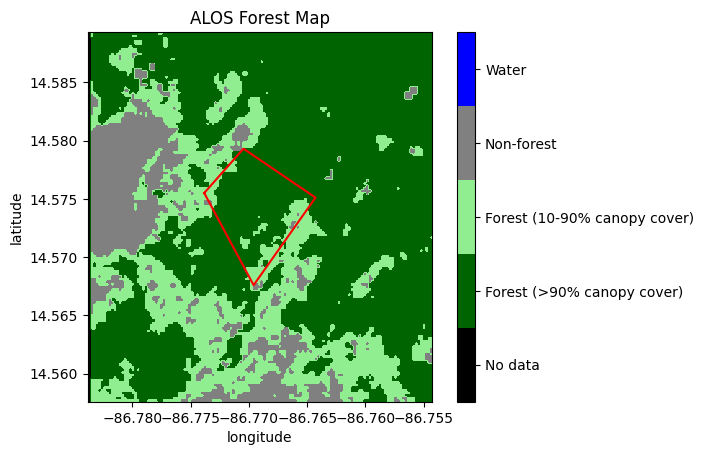

In [6]:
color_dict = {
    0: "black",
    1: "darkgreen",
    2: "lightgreen",
    3: "gray",
    4: "blue",
}

plot_categorical_map(
    out_image[0],
    color_dict,
    categories,
    geom.exterior.xy,
    extent=[minx, maxx, miny, maxy],
    title="ALOS Forest Map",
)